In [2]:
spark

In [2]:
!yum update -y -q
!yum groupinstall 'Development Tools' -y  -q
!pip install --upgrade pip -q
!pip install imbalanced-learn==0.11.0 -q
!pip install pycaret -q

Delta RPMs disabled because /usr/bin/applydeltarpm not installed.
Public key for libnccl-2.20.3-1+cuda12.3.x86_64.rpm is not installed
Importing GPG key 0xD42D0685:
 Userid     : "cudatools <cudatools@nvidia.com>"
 Fingerprint: 610c 7b14 e068 a878 070d a4e9 9cd0 a493 d42d 0685
 From       : /etc/pki/rpm-gpg/RPM-GPG-KEY-NVIDIA
There is no installed groups file.
Maybe run: yum groups mark convert (see man yum)
Delta RPMs disabled because /usr/bin/applydeltarpm not installed.


## Import Libraries

In [4]:
from pycaret.datasets import get_data
from pycaret.classification import *
import mlflow
from mlflow import log_metric, log_param, log_artifacts
from mlflow.sklearn import log_model as mlflow_log_model
from datetime import datetime
import pandas as pd
import boto3
import shutil
import os

## Prepare the Dataset

In [7]:
# Load dataset
# data = get_data('diabetes')
# Load dataset
bucket_name = 'gsproto-syntasa-bucket'
object_prefix = 'syn-file-uploads/users/zaunm/PyCaret_TestFiles' 
train = 'titanic_train.csv'
local_des_path = '/tmp/my_files'

# First lets delete all files that exist
shutil.rmtree(local_des_path, ignore_errors=True, onerror=None)

# Lets create a temporary folder locally to hold our files
os.makedirs(local_des_path, exist_ok=True)

# Create a boto3 client and download the specified object
s3_client = boto3.client('s3')
s3_client.download_file(bucket_name, f'{object_prefix}/{train}', f'{local_des_path}/{train}')

# Read the training file
train = pd.read_csv(f'{local_des_path}/{train}')

data = train

data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Initialize the Model

In [8]:
# Initialize PyCaret
exp = setup(data, target='Survived')

## Run the model

In [9]:
# Create experiment_name variable
experiment_name = "pycaret-notebook-survivor-mz"

# List of models to compare
models_to_compare = ['lr', 'knn', 'dt', 'svm', 'mlp', 'qda', 'lda','rf', 'et']
# models_to_compare = ['lr']

# Create an empty DataFrame to store models and metrics
models_metrics_df = pd.DataFrame(columns=['Model', 'Experiment', 'Algorithm', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1', 'Kappa', 'MCC', 'date_run'])

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

mlflow.set_experiment(experiment_name)

# Compare models
for model_name in models_to_compare:
    model = compare_models(include=[model_name])
    
    # Get metrics for the model
    metrics_dict = pull().to_dict()
      
    # Start MLflow run
    with mlflow.start_run(run_name=metrics_dict['Model'][model_name]) as run:
        # Log model
        mlflow_log_model(model, model_name)
        
        # Log metrics
        metric_values = []  # Collect metric values before updating the DataFrame
        for metric_name, metric_value in metrics_dict.items():
            metric_value = metric_value[model_name]
            try:
                metric_value = float(metric_value)
                mlflow.log_metric(metric_name, metric_value)
                metric_values.append(metric_value)
            except:
                continue
        
        # Add tags to indicate algorithm
        mlflow.set_tag("Model Name", metrics_dict['Model'][model_name])
        mlflow.set_tag("Date Run", today_date)
        
        # Append model and metrics information to the DataFrame
        models_metrics_df.loc[len(models_metrics_df)] = [model_name, experiment_name, model_name] + metric_values + [today_date]  
        
# Now, models_metrics_df contains information about all the models and metrics
# spark_models_metrics_df = spark.createDataFrame(models_metrics_df)


In [10]:
print(models_metrics_df)

  Model                    Experiment Algorithm  Accuracy     AUC  Recall  \
0    lr  pycaret-notebook-survivor-mz        lr    0.8202  0.8668  0.6906   
1   knn  pycaret-notebook-survivor-mz       knn    0.6501  0.6517  0.4438   
2    dt  pycaret-notebook-survivor-mz        dt    0.6164  0.5000  0.0000   
3   svm  pycaret-notebook-survivor-mz       svm    0.5412  0.0000  0.4750   
4   mlp  pycaret-notebook-survivor-mz       mlp    0.7737  0.8193  0.6699   
5   qda  pycaret-notebook-survivor-mz       qda    0.6164  0.5000  0.0000   
6   lda  pycaret-notebook-survivor-mz       lda    0.6293  0.5298  0.0522   
7    rf  pycaret-notebook-survivor-mz        rf    0.6324  0.8193  0.0418   
8    et  pycaret-notebook-survivor-mz        et    0.6918  0.7538  0.2429   

   Precision      F1   Kappa     MCC    date_run  
0     0.8231  0.7445  0.6083  0.6191  2024-02-20  
1     0.5555  0.4927  0.2311  0.2348  2024-02-20  
2     0.0000  0.0000  0.0000  0.0000  2024-02-20  
3     0.4828  0.3535  0.0

## Model Analysis

In [11]:
import plotly.express as px

### Select a model from the Pandas dataframe

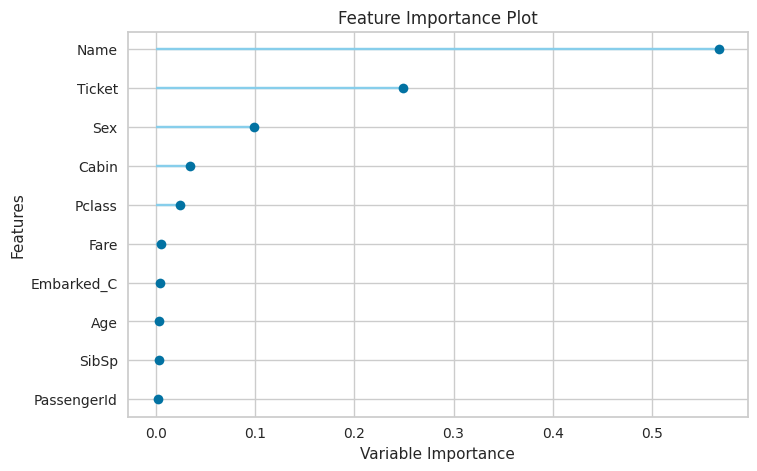

In [12]:
# check feature importance
plot_model(model, plot = 'feature')

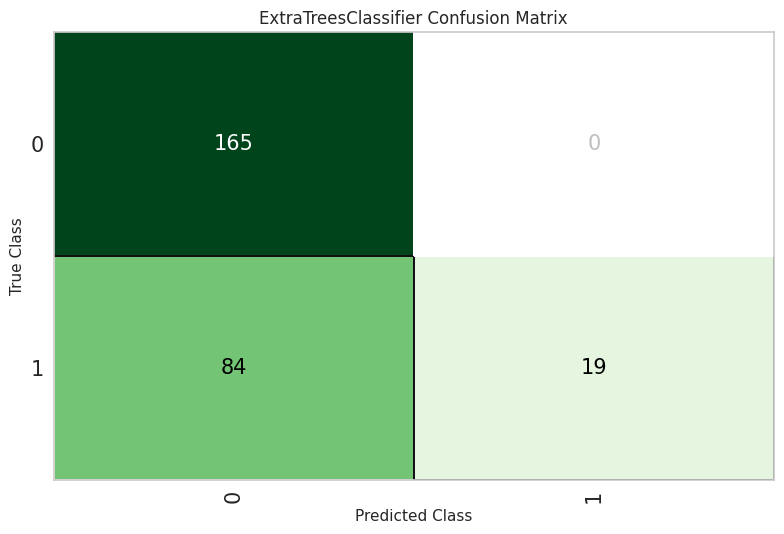

In [13]:
plot_model(model, plot = 'confusion_matrix')

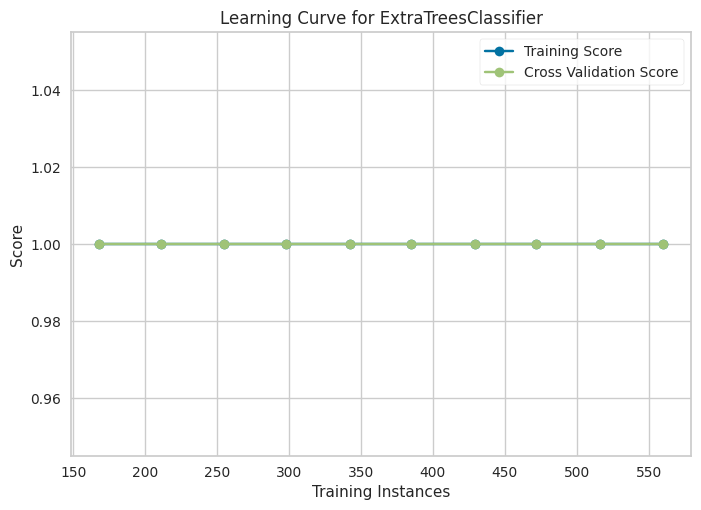

In [14]:
plot_model(model, plot = 'learning')